# (sqrt) **MLP**

---

## 0. Importing dependencies

In [228]:
%matplotlib inline

# needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from tensorflow import keras
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Activation, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import warnings

warnings.filterwarnings('ignore')

## 1. Loading data

It is already splitted:

In [229]:
train_df = pd.read_csv('../../input/clean_train_df.csv')
test_df = pd.read_csv('../../input/clean_test_df.csv')

## 2. Processing Train and Test sets

Due to class imbalace, there's still few unrelevant countries which aren't in both sets, since data is already one-hot encoded, we should find those countries and drop them off.

In [230]:
# Extract unique columns (features) from the train and test sets
train_countries = set(train_df.columns)
test_countries = set(test_df.columns)

# Find columns that are in the train set but not in the test set
missing_in_test = train_countries - test_countries
print("Columns in the train set that aren't in the test set:", missing_in_test)

missing_in_train = test_countries - train_countries
print("Columns in the test set that aren't in the train set:", missing_in_train)

# Drop columns that are in 'missing_in_test' from the training set
train_df = train_df.drop(columns=missing_in_test)

# Drop columns that are in 'missing_in_train' from the test set
test_df = test_df.drop(columns=missing_in_train)

print(train_df.shape, test_df.shape)

Columns in the train set that aren't in the test set: {'Country_Nomadic', 'Country_United Arab Emirates', 'Country_Latvia', 'Country_Saudi Arabia', 'Country_Angola', 'Ethnicity_North American / Central American', 'Country_Kosovo', 'Country_Estonia', 'Country_Bangladesh', 'Country_Croatia', 'Country_Viet Nam', 'Country_North Macedonia', 'Country_Tanzania', 'Country_Georgia', 'Country_Zimbabwe', 'Country_Venezuela', 'Country_Malta', 'Country_Serbia', 'Country_Azerbaijan', 'Country_Jordan', 'Country_Slovakia', 'Country_Bosnia-Herz.', 'Country_Costa Rica', 'Country_Yemen', 'Country_Sri Lanka', 'Country_Andorra', 'Country_Kenya', 'Country_New Zealand', 'Country_Paraguay', 'Country_Botswana', 'Country_Philippines', 'Country_El Salvador', 'Country_Lebanon', 'Country_Cyprus', 'Country_Peru', 'Country_Mongolia', 'Country_Uzbekistan', 'Country_Armenia'}
Columns in the test set that aren't in the train set: {'Country_Belarus', 'Country_Barbados', 'Country_Republic of Korea', "Country_CÃ´te d'Ivoi

___

### 2.1. Feature selection:

These cells may be needed to edit the amount of features the model will count with:

In [231]:
'''# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]

baseline_train_df.head()'''

'# Assuming you have a DataFrame called \'df\'\nbaseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]\n\n# Add Job_title columns to the baseline_cols list\nJob_title = [\'Developer, game or graphics\', \'Blockchain\', \'Developer, QA or test\', \'Developer, back-end\', \'Student\', \n             \'Project manager\', \'Data or business analyst\', \'Cloud infrastructure engineer\', \'Engineer, data\', \n             \'Educator\', \'Developer, desktop or enterprise applications\', \'Developer, front-end\', \'Designer\', \n             \'Security professional\', \'Developer, embedded applications or devices\', \'Product manager\', \'Developer, mobile\', \n             \'Developer, full-stack\', \'Scientist\', \'Database administrator\', \'Academic researcher\', \'Senior Executive (C-Suite, VP, etc.)\', \n             \'Marketing or sales professional\', \'System administrator\', \'Data scientist or machine learning specialist\', \n

In [232]:
'''X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = baseline_train_df['Annual_salary']
y_test = baseline_test_df['Annual_salary']

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)'''

"X_train = baseline_train_df.drop('Annual_salary', axis=1)\nX_test = baseline_test_df.drop('Annual_salary', axis=1)\ny_train = baseline_train_df['Annual_salary']\ny_test = baseline_test_df['Annual_salary']\n\nprint(X_train.shape)\nprint(y_train.shape)\nprint()\nprint(X_test.shape)\nprint(y_test.shape)"

---

### 2.2. Identifying the target

In [233]:
X_train = train_df.drop('Annual_salary', axis=1)
X_test = test_df.drop('Annual_salary', axis=1)
y_train = np.sqrt(train_df['Annual_salary'])
y_test = np.sqrt(test_df['Annual_salary'])
#y_train = y_train.reset_index(drop=True)

### 2.3. Standardazing data

We will standardize the data to improve model's interpretability

In [234]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This will respect col names when plotting importnce
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 3. Modeling

### 3.1. Hyperparameter tunning (K-fold CV)

Without L1 reg:

In [235]:
def create_model(optimizer='adam', init='uniform', batch_size=32, 
                 activation='relu', dropout_rate=0.0, extra_layer=True,
                 neurons=64, loss='huber_loss', epochs=25):
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer=init))
    
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
        
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons, kernel_initializer=init))  
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
        
    model.add(Dropout(dropout_rate))
    
    if extra_layer == True:
        model.add(Dense(neurons, kernel_initializer=init))  
        if activation == 'leakyrelu':
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(Activation(activation))
            
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model


With L1 reg:

In [236]:
'''from keras.regularizers import l1

def create_model(optimizer='adam', init='uniform', batch_size=32, 
                 activation='relu', dropout_rate=0.0, extra_layer=True,
                 neurons=64, loss='huber_loss', epochs=25, l1_reg=0.01):
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer=init, 
                    activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here
    
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
        
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons, kernel_initializer=init, 
                    activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
        
    model.add(Dropout(dropout_rate))
    
    if extra_layer == True:
        model.add(Dense(neurons, kernel_initializer=init, 
                        activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here
        if activation == 'leakyrelu':
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(Activation(activation))
            
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))  
    model.compile(loss=loss, optimizer=optimizer)
    
    return model'''



"from keras.regularizers import l1\n\ndef create_model(optimizer='adam', init='uniform', batch_size=32, \n                 activation='relu', dropout_rate=0.0, extra_layer=True,\n                 neurons=64, loss='huber_loss', epochs=25, l1_reg=0.01):\n    model = Sequential()\n    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer=init, \n                    activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here\n    \n    if activation == 'leakyrelu':\n        model.add(LeakyReLU(alpha=0.1))\n    else:\n        model.add(Activation(activation))\n        \n    model.add(Dropout(dropout_rate))\n    \n    model.add(Dense(neurons, kernel_initializer=init, \n                    activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here\n    if activation == 'leakyrelu':\n        model.add(LeakyReLU(alpha=0.1))\n    else:\n        model.add(Activation(activation))\n        \n    model.add(Dropout(dropout_rate))\n    \n    if extra_layer == True:\

In [237]:
model = KerasRegressor(build_fn=create_model, verbose=0)

kf = KFold(n_splits=4, shuffle=True, random_state=42)

parameters = {
    'epochs': [20], # tried with 25
    'batch_size': [64], # tried with 16 nd 64
    'optimizer': ['RMSProp'], # tried with RMSProp, SDG, Nadam
    'activation': ['leakyrelu'], # tired with elu, relu
    'init': ['he_normal'],
    'dropout_rate': [0.2], # tried with 0.3, 0.2
    'neurons': [64], # tried with 128 and 256
    'loss':['mse'], # tried with mse
    'extra_layer': [False] # Tried with False
    #, 'l1_reg': [0.001, 0.01]
}

def custom_rmse(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    mse = mean_squared_error(y_true_original, y_pred_original)
    return np.sqrt(mse)

def custom_r2(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    return r2_score(y_true_original, y_pred_original)

custom_scorer = {'r2': make_scorer(custom_r2, greater_is_better=True),  
                 'rmse': make_scorer(custom_rmse, greater_is_better=False)}

clf = RandomizedSearchCV(model, parameters, refit='rmse',
                   cv=kf, scoring=custom_scorer, return_train_score=True, n_iter=10,
                   n_jobs=-1, random_state=42, verbose=2)

clf .fit(X_train_scaled, y_train)

best_params = clf.best_params_
print(f"Best parameters found: {best_params}")

Fitting 4 folds for each of 1 candidates, totalling 4 fits


Best parameters found: {'optimizer': 'RMSProp', 'neurons': 64, 'loss': 'mse', 'init': 'he_normal', 'extra_layer': False, 'epochs': 20, 'dropout_rate': 0.2, 'batch_size': 64, 'activation': 'leakyrelu'}


#### 3.1.1. CV results

Let's look at results per parameter combination

In [238]:
pd.set_option('display.max_columns', None)

df_cv_results = pd.DataFrame(clf.cv_results_)

df_cv_results['mean_train_rmse'] = -1 * df_cv_results['mean_train_rmse']
df_cv_results['mean_test_rmse'] = -1 * df_cv_results['mean_test_rmse']

df_cv_results[['mean_train_r2', 'mean_test_r2' ,'mean_train_rmse', 'mean_test_rmse']]

,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,0.727845,0.586858,26524.287316,32645.552968


Now, the average of folds:

In [239]:
mean_test_r2 = np.mean(df_cv_results['mean_test_r2']) 
mean_test_rmse = np.mean(df_cv_results['mean_test_rmse'])  

print(f"Mean CV Test R2: {mean_test_r2}")
print(f"Mean CV Test RMSE: {mean_test_rmse}")

Mean CV Test R2: 0.5868583937237613
Mean CV Test RMSE: 32645.552967692893


### 3.2. Train and Test sets predictions

First, let's update model with the best parameters found in CV:

Now, we will define our metrics for train and test sets:

In [240]:
def adjusted_r2(r2, n, p):
    """Calculate adjusted R^2 given R^2, number of observations (n) and number of predictors (p)"""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    
def metrics(model, X, y_true, inverse_transform=True):
    """
    Calculate average metrics (R^2, RMSE, Adjusted R^2) and predictions from cross-validation results
    and return them
    """
    y_pred = model.predict(X)
    if inverse_transform:
        y_pred = np.power(y_pred, 2)  
        y_true = np.power(y_true, 2) 
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    return {'R^2': r2, 'RMSE': rmse, 'Adjusted R^2': adj_r2, 'Predictions': y_pred}

#### 3.2.1. Train set results

In [241]:
train_results = metrics(clf.best_estimator_, X_train_scaled, y_train)

print("\nTrain set metrics:")
for key in list(train_results.keys())[:3]:
    print(f"{key}: {train_results[key]}")


Train set metrics:
R^2: 0.7323181546100415
RMSE: 26313.327541157454
Adjusted R^2: 0.716091200636684


In [242]:
test_results = metrics(clf.best_estimator_, X_test_scaled, y_test)

print("\nTest set metrics:")
for key in list(test_results.keys())[:3]:
    print(f"{key}: {test_results[key]}")


Test set metrics:
R^2: 0.6153279242004825
RMSE: 30733.534997525687
Adjusted R^2: 0.49801658193538145


In [243]:
y_pred_train = train_results['Predictions']
y_pred_test = test_results['Predictions']

## 4. Plotting results

### 4.1. Residuals Plot

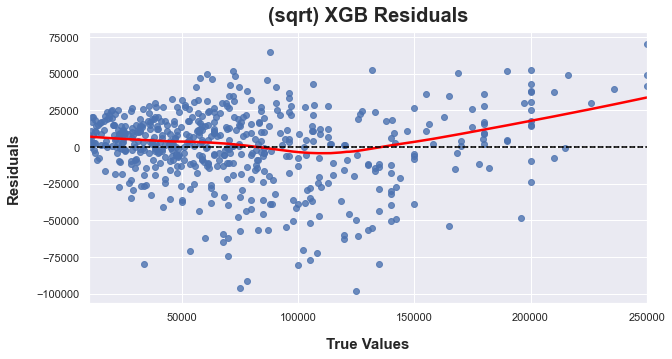

In [244]:
sns.set_theme(style='darkgrid')

residuals = np.power(y_test, 2) - y_pred_test

plt.figure(figsize=(10,5))

sns.residplot(x=np.power(y_test, 2), y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2.5})

plt.title('(sqrt) XGB Residuals', weight='bold', fontsize=20, pad=10)
plt.xlabel('True Values', weight='bold', fontsize=15, labelpad= 15)
plt.ylabel('Residuals', weight='bold', fontsize=15, labelpad= 15)
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig("../../paper/models/sqrt-xgb-test-residuals.pdf");

### 4.2. Test set performance

<Figure size 720x432 with 0 Axes>

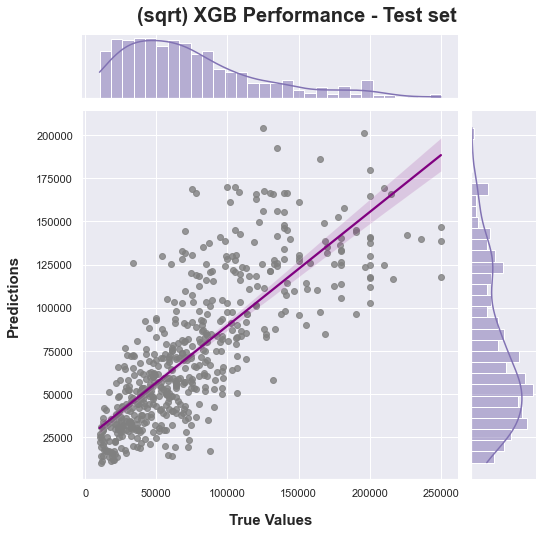

In [245]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))

sns.jointplot(x=np.power(y_test, 2), y=y_pred_test, kind='reg', 
              joint_kws={'color':'grey', 'line_kws':{'color':'purple'}},
              marginal_kws=dict(bins=30, fill=True, color='m'), height=7)

plt.suptitle('(sqrt) XGB Performance - Test set', weight='bold', y=1.03, fontsize=20)
plt.xlabel('True Values', weight='bold', labelpad=15, fontsize=15)
plt.ylabel('Predictions', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/sqrt-xgb-test-predictions.pdf");

### 4.3. Train vs Test loss

Epoch 1/20
36/36 [==============================] - 1s 10ms/step - loss: 67930.2500 - val_loss: 52729.2500
Epoch 2/20
36/36 [==============================] - 0s 5ms/step - loss: 43393.0273 - val_loss: 26994.2559
Epoch 3/20
36/36 [==============================] - 0s 5ms/step - loss: 17871.5273 - val_loss: 7535.4526
Epoch 4/20
36/36 [==============================] - 0s 5ms/step - loss: 5353.7681 - val_loss: 3365.4382
Epoch 5/20
36/36 [==============================] - 0s 4ms/step - loss: 3646.0203 - val_loss: 3000.9497
Epoch 6/20
36/36 [==============================] - 0s 5ms/step - loss: 3474.7654 - val_loss: 2871.3928
Epoch 7/20
36/36 [==============================] - 0s 4ms/step - loss: 3195.1387 - val_loss: 2863.0635
Epoch 8/20
36/36 [==============================] - 0s 4ms/step - loss: 3131.8533 - val_loss: 2871.7600
Epoch 9/20
36/36 [==============================] - 0s 5ms/step - loss: 3278.1472 - val_loss: 2782.5273
Epoch 10/20
36/36 [==============================] - 0s 4m

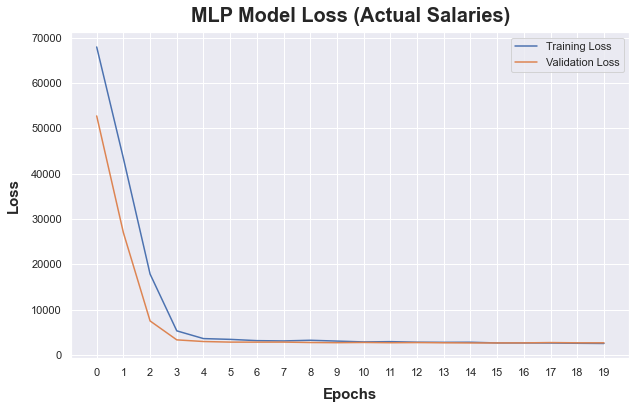

In [254]:
best_model = create_model(**best_params)

history = best_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test), 
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size']
)

train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

num_epochs = best_params['epochs']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('MLP Model Loss', fontsize=20, weight='bold', pad=10)
plt.xlabel('Epochs', fontsize=15, weight='bold', labelpad=10)
plt.ylabel('Loss', fontsize=15, weight='bold', labelpad=10)

plt.xticks(np.arange(0, num_epochs, step=1))

plt.legend()
plt.savefig("../../paper/models/actual-mlp-train-vs-test-loss.pdf")
plt.show()


## 6. Saving results

Saving CV results

In [247]:
df_cv_results.to_csv("../../output/sqrt-mlp-cv-results.csv")

Saving train and test sets predictions

In [248]:
np.savetxt("../../output/sqrt-mlp-train-predictions.csv", y_pred_train, delimiter=",")

np.savetxt("../../output/sqrt-mlp-test-predictions.csv", y_pred_test, delimiter=",")

In [249]:
pd.set_option('display.max_colwidth', None)


df_cv_results[['params', 'mean_train_r2', 'mean_test_r2', 'mean_train_rmse', 'mean_test_rmse']]

,params,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,"{'optimizer': 'RMSProp', 'neurons': 64, 'loss': 'mse', 'init': 'he_normal', 'extra_layer': False, 'epochs': 20, 'dropout_rate': 0.2, 'batch_size': 64, 'activation': 'leakyrelu'}",0.727845,0.586858,26524.287316,32645.552968
